In [1]:
# зависимости
import urllib.request as req, json, numpy as np 
# источник
apikey = "... ваш ключ ..."  # получите на https://apidata.mos.ru/Account/Login
req_template = "https://apidata.mos.ru/v1/{}/?api_key={}"
# сырые данные об открытых катках в Москве с data.mos.ru
rinks = [row["Cells"] for row in json.loads(req.urlopen(req_template.format("datasets/1231/rows", apikey)).read())]
print("Всего катков", len(rinks))

Всего катков 1398


In [2]:
# в пространстве широта-долгота
latlon =  np.array([r["geoData"]["coordinates"] for r in rinks])
# в пространстве wifi-туалет-бесплатно
convenience = [(int(r["HasWifi"] != 'нет'), int(r["HasToilet"] != 'нет'), int(r["Paid"] == 'бесплатно')) for r in rinks]

In [3]:
# выбираем топ значений, наиболее близких к эталону по метрике Евклидова расстояния
def topN(expected, data, N):
    norms = list(map(lambda row, number: (np.linalg.norm(row - expected), number), 
            data, range(len(data)) ))      # пары (расстояние, индекс)
    norms.sort(key=lambda r: r[0])         # рейтинг
    # множество индексов
    return set(map(lambda r: r[1], norms[:N]))

In [10]:
me_geo = np.array([37.676289, 55.772266])  # широта, долгота
me_conv = np.array([1.0, 1.0, 1.0])        # хочу всё: wifi, туалет и чтобы бесплатно!

depth = 1
A, B = set(), set()
# пока в пересечении ничего нет - расширяем поиск
while not A & B: 
    A = topN(me_geo, latlon, depth)
    B = topN(me_conv, convenience, depth)
    depth += 1
    
print("Мы рассматриваем", depth, "ближайших и удобных катков. Самое крутое:")
for rink in A & B:
    row = rinks[rink]
    print(row["Address"],"; Wifi:", row["HasWifi"],"; WC:", row["HasToilet"],"; Цена:", row["Paid"])

Мы рассматриваем 15 ближайших и удобных катков. Самое крутое:
улица Сокольнический Вал, дом 1, строение 1 ; Wifi: да ; WC: да ; Цена: бесплатно


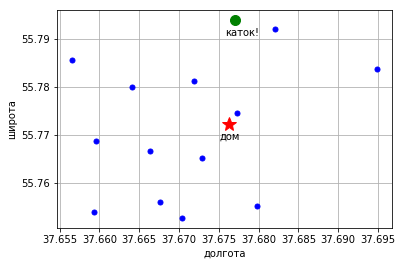

In [14]:
import matplotlib.pyplot as plt
closest = np.array([latlon[i] for i in A])
result = np.array([latlon[i] for i in A & B])
plt.plot(closest[:,0], closest[:,1], 'bo', markersize=5)
plt.plot(result[:,0], result[:,1], 'bo', markersize=10, color="green")
plt.plot(*me_geo, 'b*', markersize=15, color="red")
plt.annotate("дом", xy=me_geo, xytext=(-10, -15), textcoords='offset points')
plt.annotate("каток!", xy=result[0], xytext=(-10, -15), textcoords='offset points')
plt.grid(True)
plt.xlabel('долгота')
plt.ylabel('широта')
plt.show()